
# ISIC 2024 - Skin Cancer Detection with 3D-TBP

Nicholas Kurtansky, Veronica Rotemberg, Maura Gillis, Kivanc Kose, Walter Reade, Ashley Chow. (2024). ISIC 2024 - Skin Cancer Detection with 3D-TBP. Kaggle. 

https://kaggle.com/competitions/isic-2024-challenge

Currently heavily in development.

In [2]:
import os
import os.path as path
import gc
# import cv2
import math
import copy
import time
import random
import glob
import warnings

import h5py

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

import numpy as np
import pandas as pd

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim import lr_scheduler
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# import torchvision
# from torcheval.metrics.functional import binary_auroc
 
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# import timm

import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [3]:
# Variables

seed = 476
TIME = time.strftime("%m-%d-%H-%M-%S")

env_cfg = {
    "seed": seed,
    # "device": nn.device("cuda:0" if nn.cuda. else "cpu"),
    "device" : "GPU" if tf.config.list_physical_devices('GPU') else "CPU",
    "verbosity": '3',
}
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
verbosity = '3'

CONFIG = {
    "seed": seed, 
    "img_size": 384,
    "model_name": "",
    "checkpoint_path" : "/ISIC2024_SkinCancerDetection/saved_models",
}

In [4]:
img_size = 384
chekpoint_path = "/ISIC2024_SkinCancerDetection/saved_models"

In [5]:

print(f"Using device: {device}")
print(f"At: {TIME}")

Using device: GPU
At: 01-10-22-11-58


In [6]:
# Neural net hyperparameters 

# activation_func = 'gelu'
activation_func = 'relu'
# activation_func = 'mish'
batch_size = 16
num_epochs = 40
learning_rate = 1e-5
criterion = tf.keras.losses.BinaryCrossentropy()
# criterion = tf.keras.losses.MeanAbsoluteError()
# criterion = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

initializer = tf.keras.initializers.GlorotUniform(seed=CONFIG["seed"])

In [7]:
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = env_cfg["verbosity"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = env_cfg["verbosity"]

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

tf.debugging.set_log_device_placement(False)

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
def set_seed(seed=42):

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
set_seed(seed)

In [11]:
# https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only#Training-Function

ROOT_DIR = path.normpath("./data/")
TRAIN_DIR = f'{ROOT_DIR}/train-image/image/'

train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
print(TRAIN_DIR)
print("Number of train_images:", len(train_images))

data/train-image/image/
Number of train_images: 401059


In [12]:
train_images[:5]

['data/train-image/image\\ISIC_0015670.jpg',
 'data/train-image/image\\ISIC_0015845.jpg',
 'data/train-image/image\\ISIC_0015864.jpg',
 'data/train-image/image\\ISIC_0015902.jpg',
 'data/train-image/image\\ISIC_0024200.jpg']

In [13]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

print(get_train_file_path("ISIC_0015864"))
# img = cv2.imread(get_train_file_path("ISIC_0015864"))

# plt.imshow(img)

data/train-image/image//ISIC_0015864.jpg


In [14]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [15]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isic_id,401059,401059,ISIC_0015670,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,401059.0,NaN,NaN,NaN,0.00098,0.031288,0.0,0.0,0.0,0.0,1.0
patient_id,401059,1042,IP_1117889,9184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,398261.0,NaN,NaN,NaN,58.012986,13.596165,5.0,50.0,60.0,70.0,85.0
sex,389542,2,male,265546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,395303,5,posterior torso,121902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,401059.0,NaN,NaN,NaN,3.930827,1.743068,1.0,2.84,3.37,4.38,28.4
image_type,401059,1,TBP tile: close-up,401059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,401059,2,3D: XP,285903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,401059.0,NaN,NaN,NaN,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961


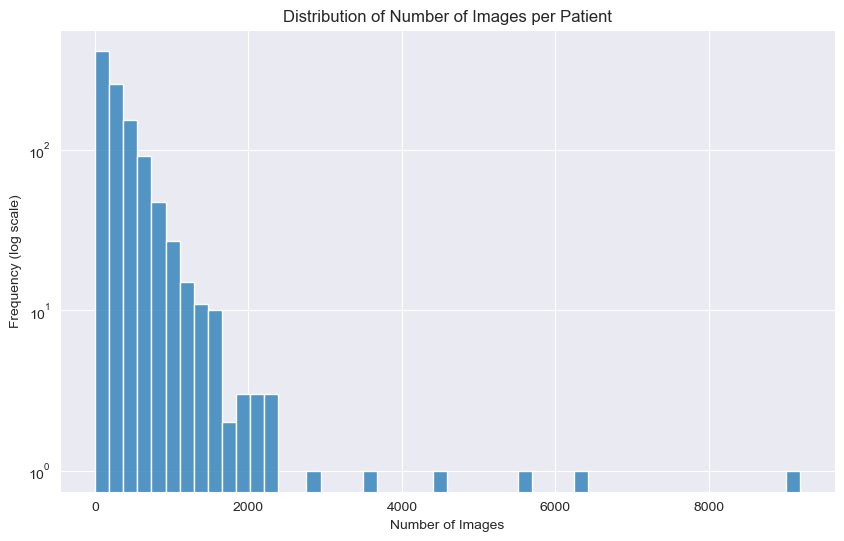

In [16]:
id_values = df["patient_id"].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(id_values, bins=50, kde=False)
plt.yscale('log')
plt.title('Distribution of Number of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Frequency (log scale)')
plt.show()

In [17]:
patient_with_most_images = id_values.idxmax()
most_images_count = id_values.max()

print(f"Patient ID with the most images: {patient_with_most_images}")
print(f"Number of images: {most_images_count}")

Patient ID with the most images: IP_1117889
Number of images: 9184


In [18]:
patient_with_most_images_entries = df[df.patient_id  == patient_with_most_images]
print(patient_with_most_images_entries)

             isic_id  target  patient_id  age_approx     sex  \
23      ISIC_0052122       0  IP_1117889        55.0  female   
47      ISIC_0073261       0  IP_1117889        55.0  female   
79      ISIC_0074118       0  IP_1117889        55.0  female   
104     ISIC_0075822       0  IP_1117889        55.0  female   
140     ISIC_0076635       0  IP_1117889        55.0  female   
...              ...     ...         ...         ...     ...   
400976  ISIC_9998037       0  IP_1117889        55.0  female   
401043  ISIC_9999596       0  IP_1117889        55.0  female   
401048  ISIC_9999779       0  IP_1117889        55.0  female   
401049  ISIC_9999817       0  IP_1117889        55.0  female   
401050  ISIC_9999852       0  IP_1117889        55.0  female   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
23          anterior torso                    2.60  TBP tile: close-up   
47          anterior torso                    6.19  TBP tile: close-up   
79       

In [19]:
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

print("Unique patients:",  df["patient_id"].unique().shape[0])
print()

print("Positive patient images:", df_positive.shape[0])
print("Unique patients with positive images:",  df_positive["patient_id"].unique().shape[0])
print()

print("Negative patient images:", df_negative.shape[0])
print("Unique patients with negative images:",  df_negative["patient_id"].unique().shape[0])

Unique patients: 1042

Positive patient images: 393
Unique patients with positive images: 259

Negative patient images: 400666
Unique patients with negative images: 1041


In [20]:
neg, pos = df["target"].value_counts()
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 401059
    Positive: 393 (0.10% of total)



In [21]:
# Imbalanced dataset fix

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*7, :]])  
print("Reduced dataset shape:", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)

# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)

df.head()

Reduced dataset shape: (3144, 55) 393 (788,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,data/train-image/image//ISIC_0082829.jpg
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,data/train-image/image//ISIC_0096034.jpg
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,data/train-image/image//ISIC_0104229.jpg
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,data/train-image/image//ISIC_0119495.jpg
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,data/train-image/image//ISIC_0157834.jpg


In [22]:
print("Number of unique patients after balancing: ", df["patient_id"].nunique())

Number of unique patients after balancing:  788


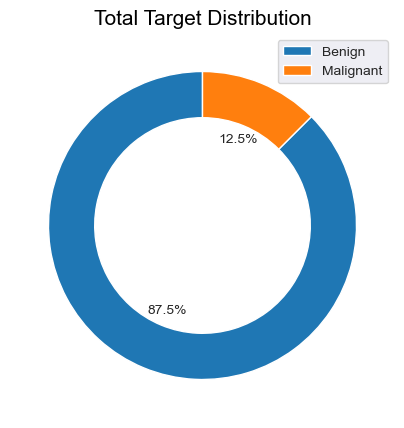

In [23]:
name = ['Benign', 'Malignant']

plt.figure(figsize = (5, 5))
plt.pie(df.target.value_counts(normalize = True), autopct = '%1.1f%%', startangle = 90, wedgeprops = dict(width = 0.3), 
        labeldistance = 1.2, radius = 1)
plt.title(f'Total Target Distribution', color = 'black', fontsize = 15)
plt.legend(name,)

plt.show()

In [24]:
missing_values_count = df.isnull().sum()
print(sorted(missing_values_count, reverse=True))

[3144, 3091, 3081, 2901, 2745, 2745, 2591, 100, 25, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
multi_data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                # mean=[0.485, 0.456, 0.406], 
                # std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.
                       ),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                # mean=[0.485, 0.456, 0.406], 
                # std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
        ], p=1.
                       )
}


In [26]:
single_transforms = A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                # mean=[0.485, 0.456, 0.406], 
                # std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.
    )

In [27]:
def mult_aug_fn(image, img_size, train):
    data = {"image":image}
    aug_data = multi_data_transforms(**data["train" if train else "valid"])
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [28]:
def apply_single_img_augmentation(image, img_size=CONFIG['img_size']):
    image = np.array(image)
    
    if image.shape[0] <= 0 or image.shape[1] <= 0:
        raise ValueError("Image has non-positive dimensions")
    
    aug_data = single_transforms(image=image)
    aug_img = aug_data["image"]
    
    # image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    resized = tf.image.resize(aug_img, size=[img_size, img_size])

    return resized

In [29]:
def augment_multi_modal(image, img_size):
    aug_img = tf.numpy_function(func=mult_aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [30]:
def augment_single_img(image, label, img_size=CONFIG['img_size']):
    aug_img = tf.numpy_function(func=apply_single_img_augmentation, inp=[image, img_size], Tout=tf.float32)
    aug_img.set_shape([img_size, img_size, 3])
    # ensure_shape
    
    return aug_img, label

In [31]:
# Manual loading, too slow
# x_train = []
# y_train = []
# with h5py.File('ISIC2024_SkinCancerDetection/data/train-image.hdf5', 'r') as f:
#        keys = list(f.keys())
#        for key in keys:
#            data = f[key]
#            x_train.append(data[()].decode('latin-1'))
#            
#            # x_train.append(f[key][:]) 
#            y_train.append(key)
#               
# print(len(x_train), len(y_train))
# print(x_train[:5], y_train[:5])

In [32]:
training_validation_hdf5 = h5py.File(f"{ROOT_DIR}/train-image.hdf5", 'r', libver='earliest')

In [33]:
# Example

isic_id = df.isic_id.iloc[10]

byte_string = training_validation_hdf5[isic_id][()]
# print(f"Byte String: {byte_string[:20]}....")

nparr = np.frombuffer(byte_string, np.uint8)

# image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
#print(f"Image: {image}")

# plt.imshow(image);
# print(f"First image shape: {image.shape}.")

In [34]:
# Load all images

data_ids = df.isic_id.values

images = [None]*len(data_ids)
for i, isic_id in enumerate(data_ids):
    images[i] = training_validation_hdf5[isic_id][()]

print(f"Loaded {len(images)} images.")

del training_validation_hdf5

Loaded 3144 images.


In [35]:
# import concurrent.futures
# from PIL import Image

# def load_and_convert_image(image_path):
#     # img = cv2.imread(image_path)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # return img
#     with Image.open(image_path) as img:
#         img = img.convert('RGB')
#         img = img.resize((CONFIG["img_size"], CONFIG["img_size"]))
#         return np.array(img)

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     mg = list(executor.map(load_and_convert_image, train_images))

# print(f"Loaded {len(mg)} images.")
# print(f"First image shape: {mg[0].shape}.")
# print(f"First image: {mg[0]}.")

In [36]:
# hist = [cv2.calcHist([cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)], [0], None, [256], [0, 256]) for img in images]
# hist = np.array(hist).squeeze()
# plt.plot(hist[0], label="Blue")

In [37]:
# Based on https://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter

def decoder(only_image=False, with_labels=True, target_size=(256, 256)):
    
    def decode_only_image(file_bytes, label):
        
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        return image, label
    
    def decode_image(inp):
        
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp
    
    
    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label
    
  
    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, 1)
        return inp, label
    
    if only_image:
        return decode_only_image
    return decode_with_labels if with_labels else decode_image

multi_decoder = decoder(with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))
image_decoder = decoder(only_image=True, with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))

In [38]:
# Too slow
# decoded_images = [cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)[...,::-1] for img in images]

In [39]:
# Multimodal dataset

# inp = {
#     "images": images, 
#     "features": features
#        }

# slices = (inp, df.target.values)

# ds = tf.data.Dataset.from_tensor_slices(slices)
 
# ds = tf.data.Dataset.from_tensor_slices(images, df.target.values)
# ds = ds.cache()
# ds = ds.map(decoder, num_parallel_calls=AUTOTUNE)

# ds = ds.shuffle(1024, seed=seed)
# opt = tf.data.Options()
# opt.deterministic = False
# ds = ds.with_options(opt)

# ds = ds.batch(CONFIG['train_batch_size'], drop_remainder=True)

# ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
# ds = ds.prefetch(AUTOTUNE)

In [40]:
# Manual decoding, too slow

# decoded_images = []
# target_size=(CONFIG["img_size"], CONFIG["img_size"])
# 
# for file_bytes in images:
#     with tf.device("/CPU:0"):
#         image = tf.io.decode_jpeg(file_bytes)
# 
#         image = tf.image.resize(image, size=target_size, method="area")
# 
#         image = tf.cast(image, tf.float32)
#         image /= 255.0
# 
#         image = tf.reshape(image, [*target_size, 3])
# 
#         decoded_images.append(image)
# 
# decoded_images = tf.stack(decoded_images)
# 
# decoded_images_np = decoded_images.numpy()
# 
# 
# print(decoded_images_np.shape)

In [41]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Memory growth not supported.")
    pass
    # Invalid device or cannot modify virtual devices once initialized.

In [42]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)

In [43]:
tf.config.experimental.get_memory_info('GPU:0')

{'current': 0, 'peak': 0}

In [44]:
image = images[23]
decoded_image = image_decoder(image, df.target.values[0])
# print(decoded_image)
augmented_image = single_transforms(image=np.array(decoded_image[0]))

from PIL import Image

arr = (np.asarray(decoded_image[0].numpy()) * 255).astype(np.uint8)

print(arr.shape)

# Image.fromarray((decoded_image[0].numpy() * 255).astype(np.uint8) ).show()

(384, 384, 3)


In [46]:
# Image.fromarray(arr).show()

In [47]:
# Single image dataset

dataset = tf.data.Dataset.from_tensor_slices((images, np.int8(df.target.values)))

options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False

options.experimental_distribute.auto_shard_policy = (tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

dataset = dataset.with_options(options)

print(f"Dataset size: {dataset.cardinality().numpy()}")

dataset = dataset.map(image_decoder, num_parallel_calls=AUTOTUNE)

augmented_dataset = dataset.map(augment_single_img, num_parallel_calls=AUTOTUNE)
dataset = dataset.concatenate(augmented_dataset)


print(f"Dataset size: {dataset.cardinality().numpy()}")

# dataset = dataset.cache()

# dataset = dataset.shuffle(buffer_size=ds_size)

with tf.device('/CPU:0'):
    train_ds, valid_ds = tf.keras.utils.split_dataset(dataset, left_size=0.8, shuffle=True, seed=seed)

# train_ds = train_ds.cache()
# valid_ds = valid_ds.cache()

print(f"Training dataset size: {train_ds.cardinality().numpy()}")
print(f"Validation dataset size: {valid_ds.cardinality().numpy()}")

Dataset size: 3144
Dataset size: 6288
Training dataset size: 5030
Validation dataset size: 1258


In [48]:
del dataset
del augmented_dataset, images

In [ ]:
import psutil

# train_size = int(0.8 * ds_size)
# train_ds = dataset.take(train_size)
# valid_ds = dataset.skip(train_size)

# train_labels = [sample[1] for sample in train_ds.as_numpy_iterator()]
# valid_labels = [sample[1] for sample in valid_ds.as_numpy_iterator()]
# train_labels = [labels.numpy() for _, labels in train_ds]
# valid_labels = [labels.numpy() for _, labels in valid_ds]

train_labels = []
for _, label in train_ds.as_numpy_iterator():
    print(label)
    train_labels.append(label)

# Apply batching
train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
valid_ds = valid_ds.batch(batch_size=batch_size, drop_remainder=True)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Training dataset size: {train_ds.cardinality().numpy()}")
print(f"Validation dataset size: {valid_ds.cardinality().numpy()}")

In [ ]:
# Sanity check

# train_labels, valid_labels = [], []
# 
# train_hashes = set()
# valid_hashes = set()
# 
# optional_computing = False
# 
# # Convert images to hashes for faster comparison
# for img, label in train_ds.unbatch().as_numpy_iterator():
#     if optional_computing:
#         train_hashes.add(hash(img.tobytes()))
#     train_labels.append(label)
# 
# for img, label in valid_ds.unbatch().as_numpy_iterator():
#     if optional_computing:
#         valid_hashes.add(hash(img.tobytes()))
#     valid_labels.append(label)
# 
# if optional_computing:
#     duplicates = []
#     for img_hash in train_hashes.keys():
#         if img_hash in valid_hashes:
#             duplicates.append((train_hashes[img_hash], valid_hashes[img_hash]))
#             
#     print(f"Number of duplicates: {len(duplicates)}")
#     print(duplicates)
# 
# del train_hashes, valid_hashes

In [ ]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {valid_labels.mean():.4f}')

In [ ]:
# train_c = 0
# val_c = 0
# 
# for batch in train_ds:
#     train_c += sum(batch[1])
# 
# for batch in valid_ds:
#     val_c += sum(batch[1])
# 
# print(train_c, val_c)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)    
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        
        #self.flatten_layer = keras.layers.Flatten(name="flatten")

        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                            input_shape=(batch_size, 384, 384, 3),
                                            activation=activation_func
                                            )
        # self.pool1 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                            activation=activation_func, 
                                            # strides=(2, 2)
                                            )
        self.pool2 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                            activation=activation_func,
                                            # strides=(2, 2)
                                            )
        # self.pool3 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        self.pool4 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        
        self.conv55 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        self.pool5 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        self.pool6 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        self.conv8 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                                            activation=activation_func
                                            )
        self.pool7 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # self.conv8 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
        #                                     activation=activation_func
        #                                     )
        
        # self.conv9 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
        #                                     activation=activation_func
        #                                     )
        # self.pool8 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        
        self.flatten = tf.keras.layers.Flatten()
    

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(1):
            self.hidden_layers.append(tf.keras.layers.Dense(512, activation=activation_func, 
                                                            kernel_initializer="he_normal",
                                                            kernel_regularizer=tf.keras.regularizers.L1(0.01))
                                      )
            self.hidden_layers.append(tf.keras.layers.Dropout(0.3))
            # self.hidden_layers.append(tf.keras.layers.BatchNormalization())


        self.fc = []
        for i in range(1):
            self.fc.append(tf.keras.layers.Dense(256, activation=activation_func,
                                                                kernel_initializer="he_normal",
                                                                kernel_regularizer=tf.keras.regularizers.L1(0.01))
                                          )
            # self.hidden_layers.append(tf.keras.layers.BatchNormalization())

        self.output_layer = tf.keras.layers.Dense(1, 
                                                  activation='sigmoid',
                                                #   bias_initializer=tf.keras.initializers.Constant(np.log([pos/neg]))
                                                  )


    def call(self, x):
        x = self.conv1(x)
        # x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        # x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.conv55(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.conv7(x)
        x = self.pool7(x)
        # x = self.conv8(x)
        # x = self.conv9(x)
        # x = self.pool8(x)

        x = self.flatten(x)
        
        # for layer in self.feature_extractor:
        #     x = layer(x)

        for layer in self.hidden_layers:
            x = layer(x)

        for layer in self.fc:
            x = layer(x)

        return self.output_layer(x)

model = Net()

In [ ]:
# Callbacks

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    f"{ROOT_DIR}/chkpts/checkpoint.keras.model{TIME}",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    initial_value_threshold=0.85,
), tf.keras.callbacks.TensorBoard(log_dir=f"{ROOT_DIR}/logs",
                                  histogram_freq=0,
                                  write_steps_per_second=True,
                                  write_images=False,
                                  ), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,
                                                                      restore_best_weights=True,
                                                                      verbose=1
                                                                      ), tf.keras.callbacks.ProgbarLogger()]

In [ ]:
# Class weights

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0) # * (1/8)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
from sklearn.utils import class_weight

sk_class_weights = dict(enumerate(
    class_weight.compute_class_weight('balanced', 
                                      classes=[0, 1], 
                                      y=np.concatenate([train_labels, valid_labels])
                                      )
                                  )
                        )

print("SK Weights:", sk_class_weights)

In [ ]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, callbacks=callbacks, 
                    # class_weight=sk_class_weights,
                    use_multiprocessing=True,
                    verbose=2
                    )   

In [ ]:
model.summary()

In [ ]:
results = model.evaluate(valid_ds)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

In [ ]:
def plot_loss(history, label, n):
  
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot_loss(history, "Binary Crossentropy", 0)

In [ ]:
# Plot accuracy

def plot_accuracy(history, label, n):
  
  plt.plot(history.epoch, history.history['accuracy'],
               color=colors[n], label='Train ' + label)
  
  plt.plot(history.epoch, history.history['val_accuracy'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plot_accuracy(history, "Accuracy", 0)

In [ ]:
print(history.history.keys())

In [ ]:
def plot_metrics(history):
  metrics = ['f1_m', 'loss', 'precision_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

In [ ]:
train_predictions_baseline = model.predict(train_ds, batch_size=batch_size)
valid_predictions_baseline = model.predict(valid_ds, batch_size=batch_size)

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('(True Positives): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

In [ ]:
train_pred_bool = np.argmax(train_predictions_baseline, axis=1)

print(classification_report(train_labels, train_pred_bool))

In [ ]:
valid_y_pred_bool = np.argmax(valid_predictions_baseline, axis=1)

print(classification_report(valid_labels, valid_y_pred_bool))

In [ ]:
plot_cm(train_labels, train_predictions_baseline)

In [ ]:
plot_cm(valid_labels, valid_predictions_baseline)

In [ ]:
plot_cm(valid_labels, valid_predictions_baseline, threshold=0.1)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-1.5,101.5])
  plt.ylim([0,101.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", valid_labels, valid_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", valid_labels, valid_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower left');

In [ ]:
# Testing

test_hdf5 = h5py.File(f"{ROOT_DIR}/test-image.hdf5", 'r')
test_df = pd.read_csv(f"{ROOT_DIR}/test-metadata.csv")
test_ids = test_df.isic_id.values
print(test_df)

test_images = [None]*len(test_ids)
test_labels = [None]*len(test_ids)

for i, isic_id in enumerate(test_ids):
    if isic_id in test_hdf5:
        if test_hdf5[isic_id][()] is not None:
            test_images[i] = test_hdf5[isic_id][()]
            test_labels[i] = test_df[isic_id].target

print(f"Loaded {len(images)} images.")

test_dataset = tf.data.Dataset.from_tensor_slices(test_images, test_labels)

test_dataset = test_dataset.cache()

test_dataset = test_dataset.map(image_decoder, num_parallel_calls=AUTOTUNE)

test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=True)

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Testing dataset size: {test_dataset.cardinality().numpy()}")

predictions = model.predict(test_dataset)

In [ ]:
# Submission

image_ids = []
predictions = []

with h5py.File("I/SIC2024_SkinCancerDetection/data/test-image.hdf5", 'r') as hdf:
    for key in hdf.keys():
        dataset = hdf[key]
        if isinstance(dataset, h5py.Dataset):
            
            img_data = dataset[()]
            img_data = np.frombuffer(img_data, dtype=np.uint8)
            img = Image.open(io.BytesIO(img_data))

            img = test_transform(img)

            img = img.unsqueeze(0).to(CONFIG['device']) 

            output = model(img)
            # probability = output.squeeze().cpu().item()

            image_ids.append(key)
            predictions.append(output)

submission_df = pd.DataFrame({
    'isic_id': image_ids,
    'target': predictions 
})

submission_df.to_csv('submission.csv', index=False)

In [ ]:
# TODO: Custom training loop with evaluation